## Setup

In [1]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import json
import re
import nltk
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/News_Category_Dataset_v3.json'

df = pd.read_json(file_path, lines=True)
df = df.sample(frac=0.3, random_state=42)

## Data Clean Up and Processing

In [5]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [6]:
## clean text

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text).lower())

    tokens = word_tokenize(text)

    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]

    cleaned_text = ' '.join(tokens)

    return cleaned_text

df['cleaned_headline'] = df['headline'].apply(preprocess_text)
df['cleaned_short_description'] = df['short_description'].apply(preprocess_text)

In [7]:
## check results
print(df[['cleaned_headline', 'cleaned_short_description', 'category']])

                                         cleaned_headline  \
128310                               famili gener changer   
139983                  firestorm aol employe benefit cut   
42339   dakota access protest arrest deadlin pass depa...   
131494                 one glimps babi kit fox youll hook   
163649  men sweat pheromon androstadienon influenc coo...   
...                                                   ...   
73267        molten salt water goe kaboom like hope would   
77785               exda expect key defens wit cosbi hear   
18191                   joe biden say wish abl anita hill   
188052  wind power product tax credit creat green job ...   
157178                   redefin cycl tradit relationship   

                                cleaned_short_description     category  
128310  wont creat new opportun well also uncov way cr...       IMPACT  
139983  gloriou week aol chief execut tim armstrong co...     BUSINESS  
42339             protest refus leav remain site

## Exploratory Data Analysis (EDA)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

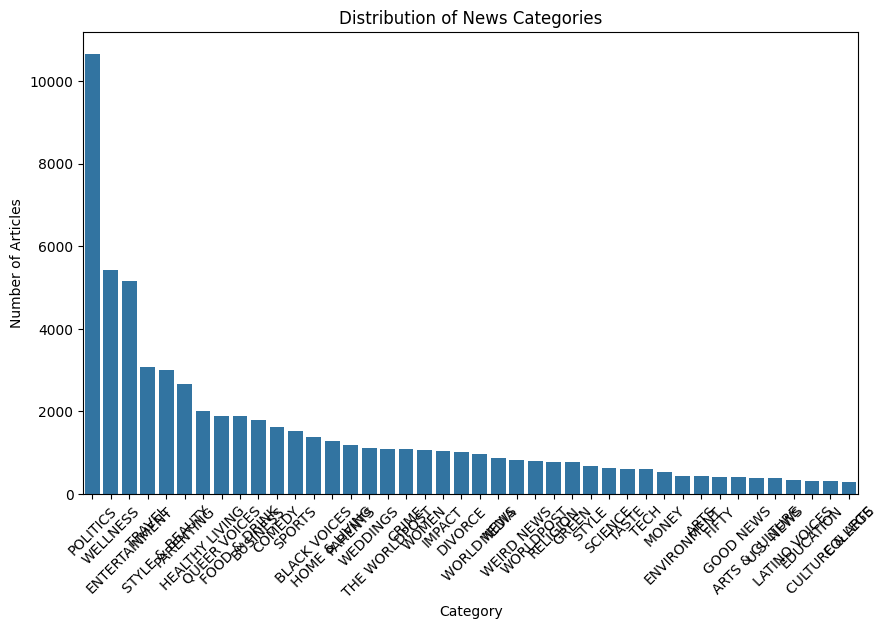

In [9]:
## examine distribution of news categories to see potential impact on model; helps analyze if any classes are imbalanced

category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of News Categories')
plt.xticks(rotation=45)
plt.show()

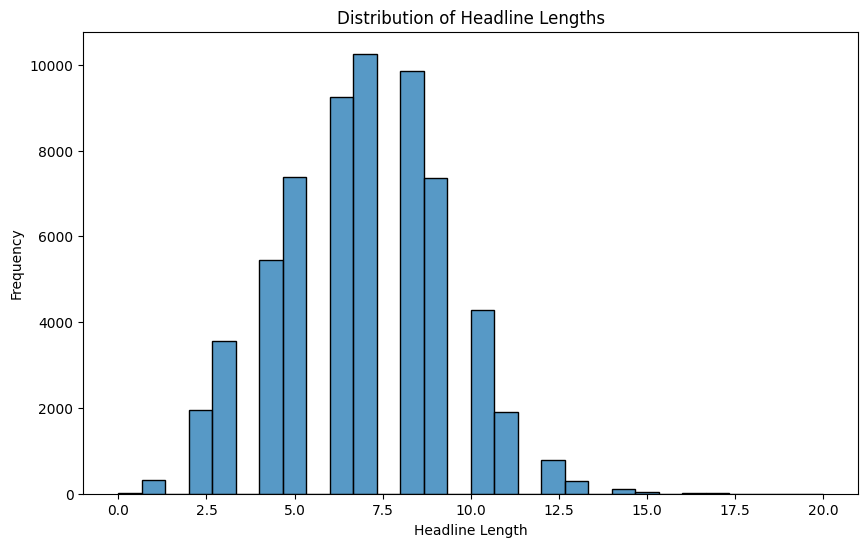

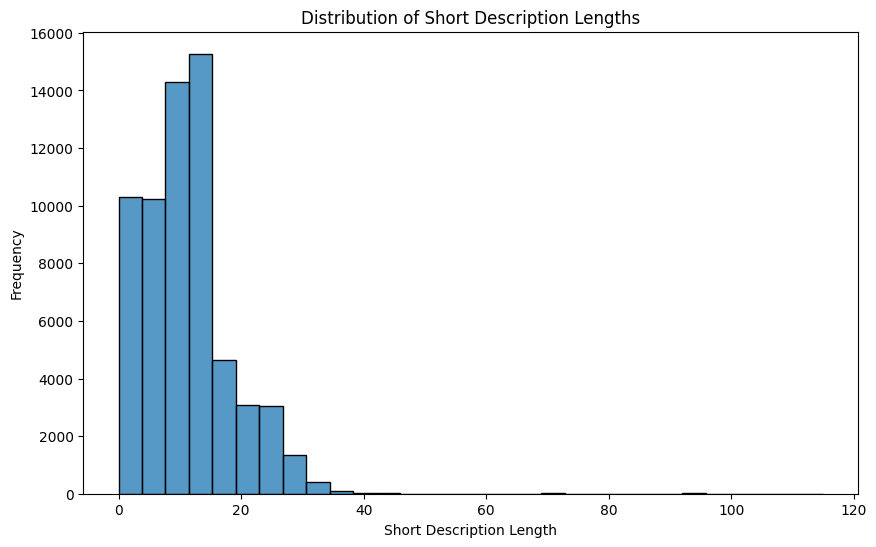

In [10]:
## look at the length of headlines and short descriptions; helps determine if we should remove text

df['headline_length'] = df['cleaned_headline'].apply(lambda x: len(x.split()))
df['description_length'] = df['cleaned_short_description'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30)
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.title('Distribution of Headline Lengths')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['description_length'], bins=30)
plt.xlabel('Short Description Length')
plt.ylabel('Frequency')
plt.title('Distribution of Short Description Lengths')
plt.show()

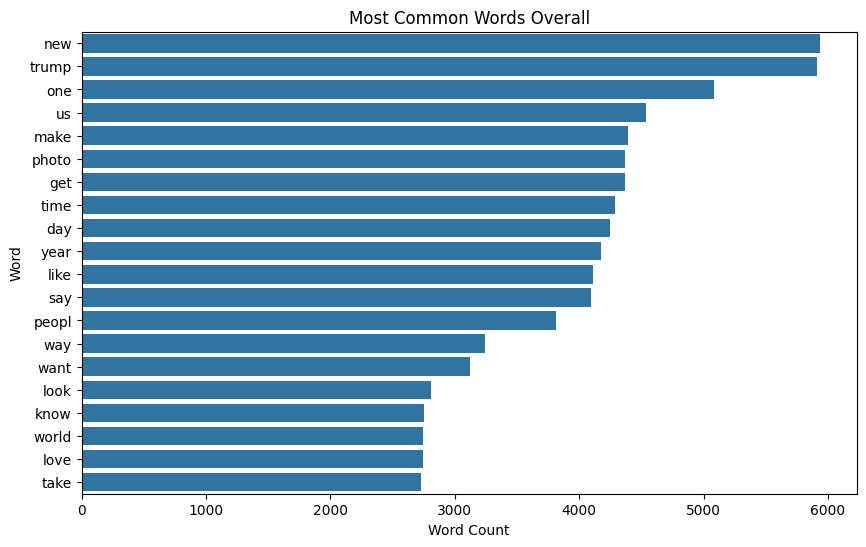

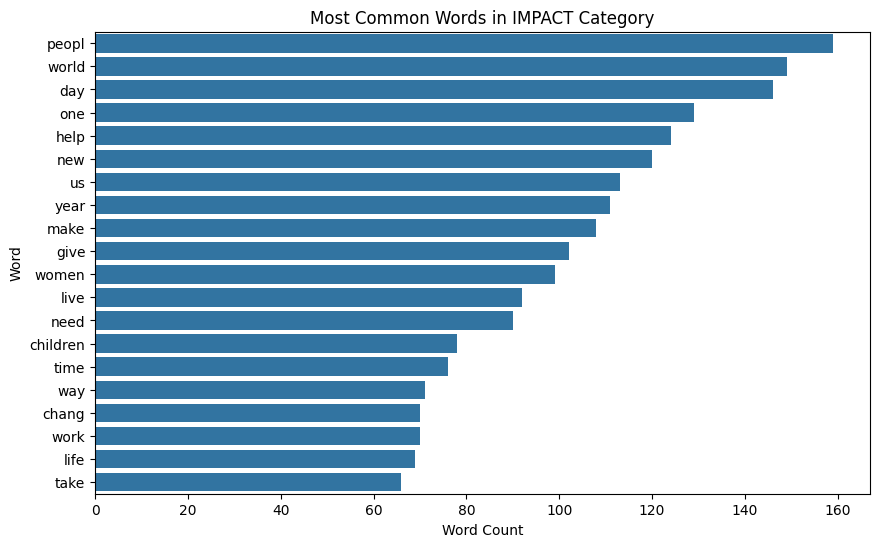

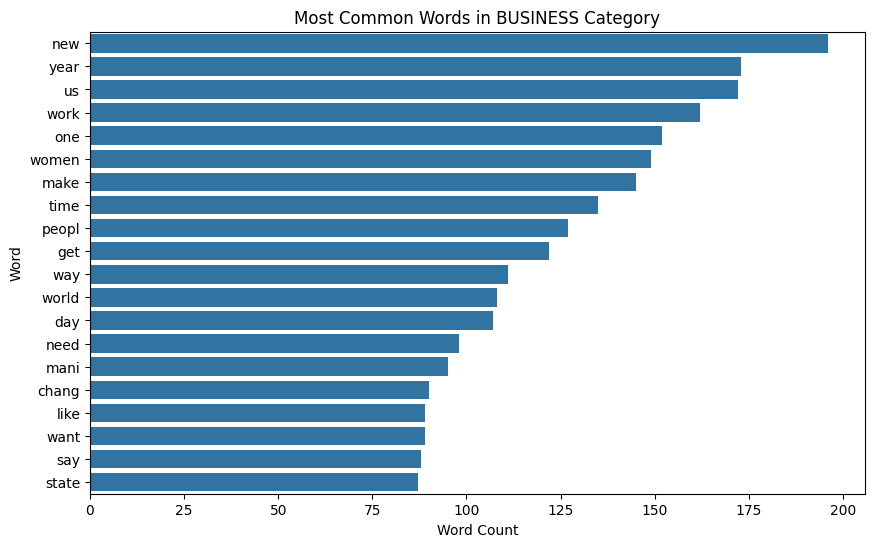

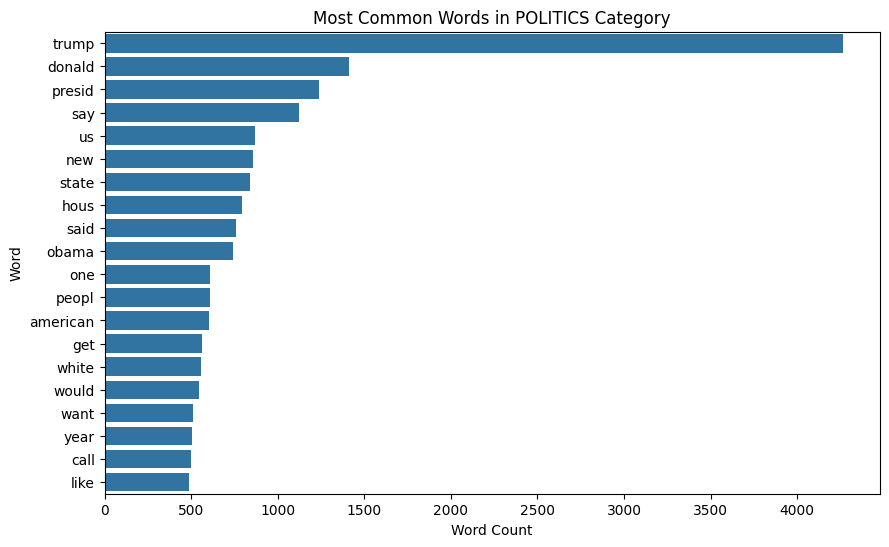

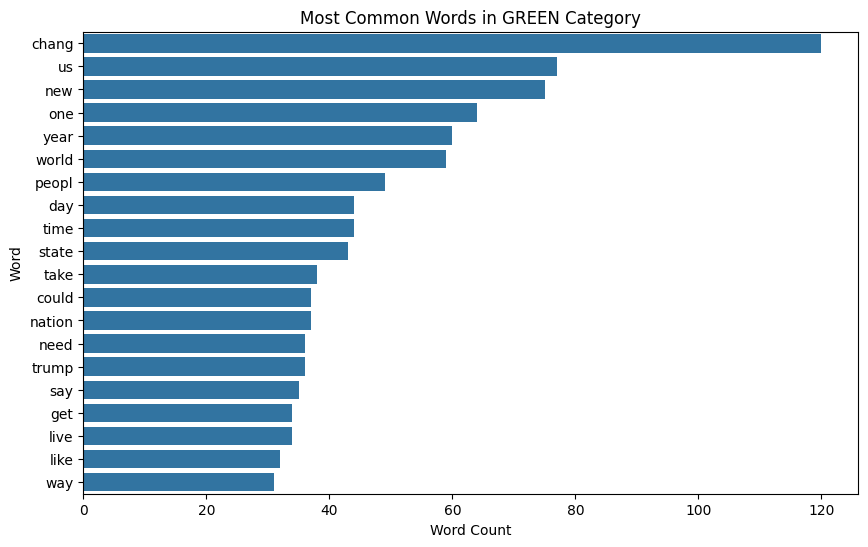

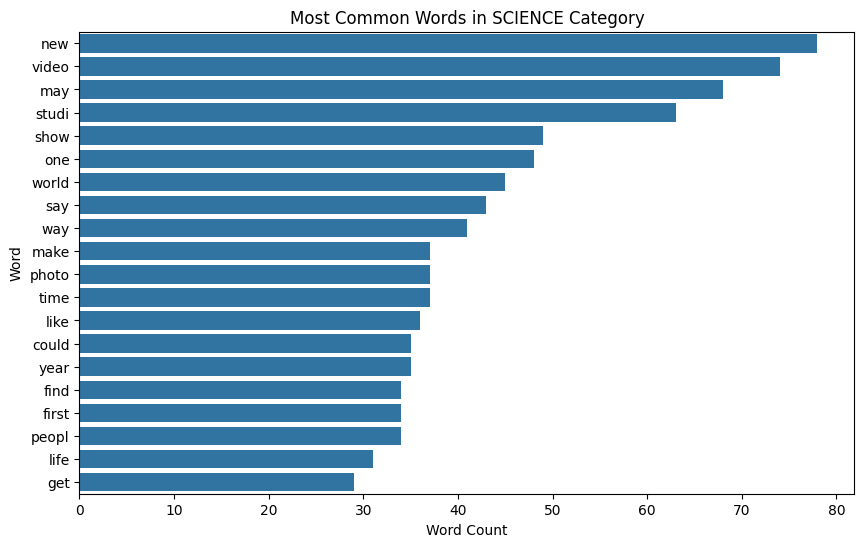

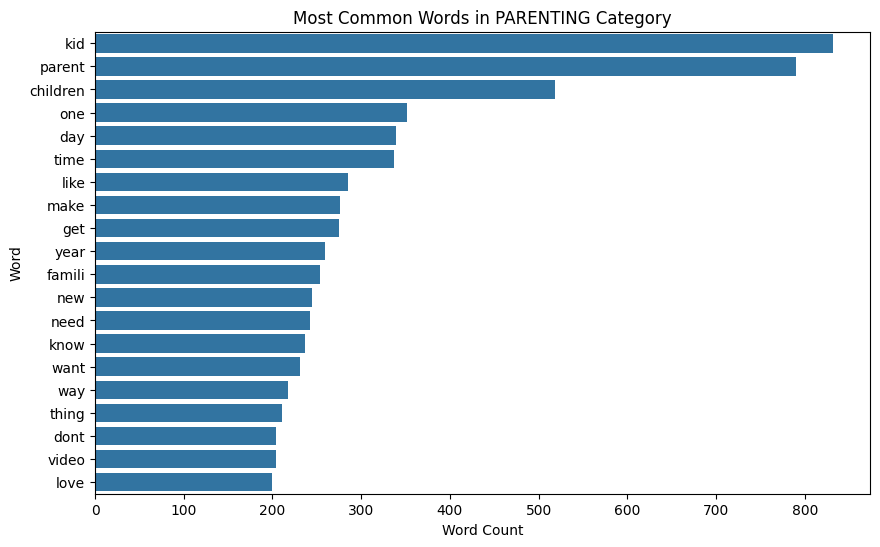

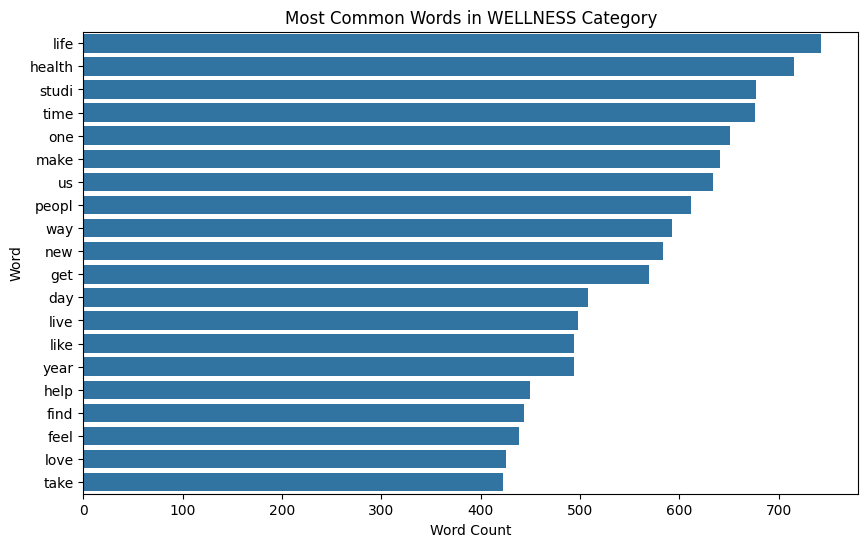

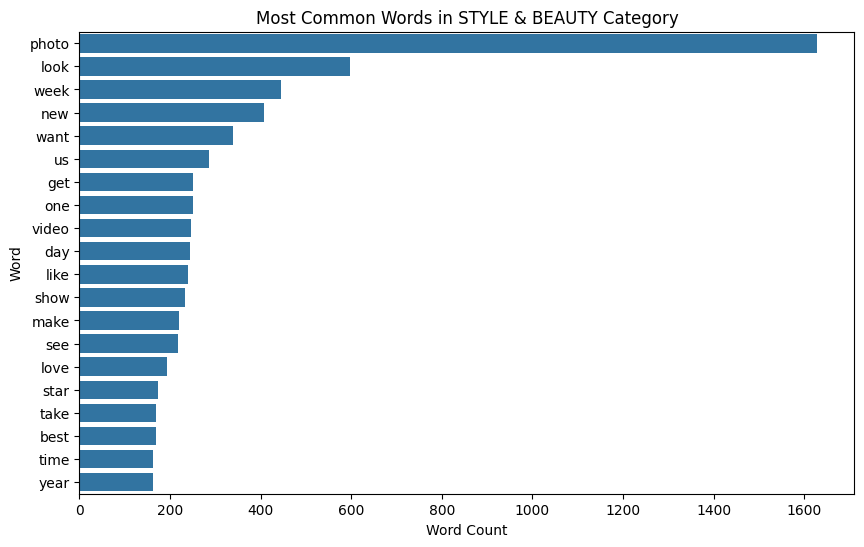

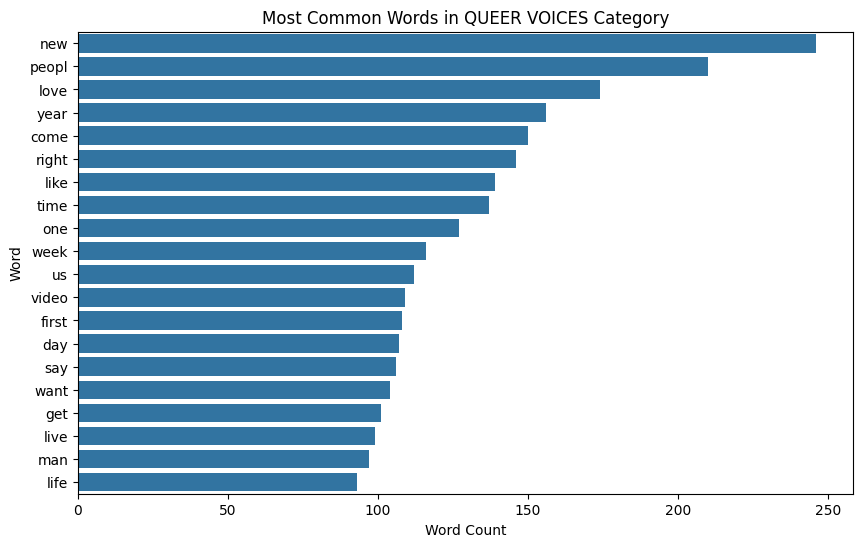

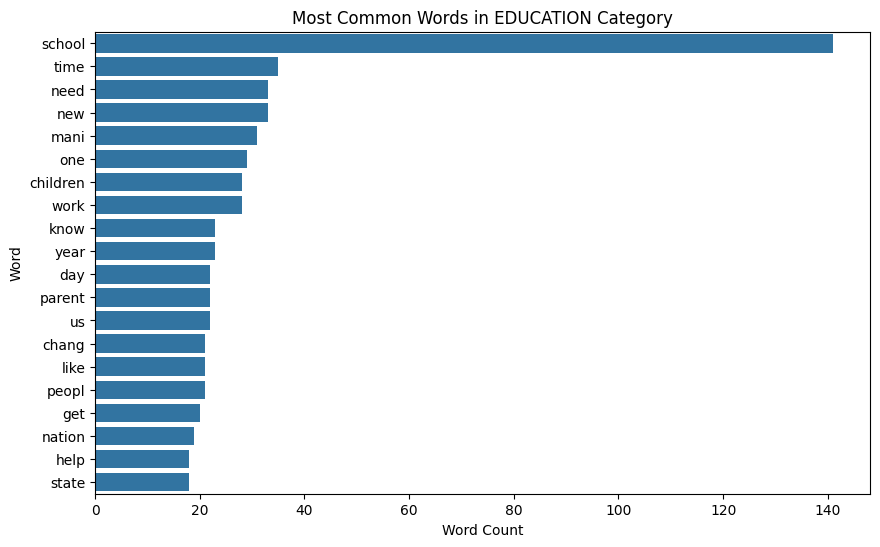

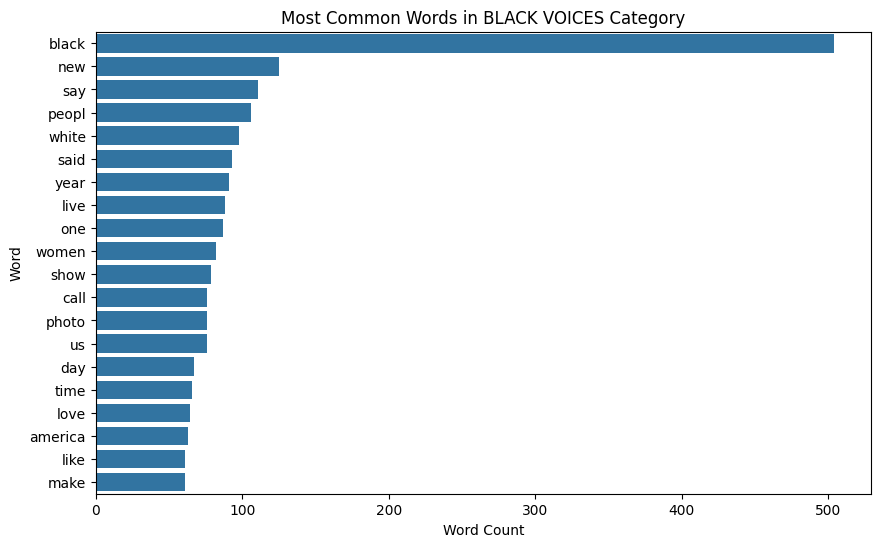

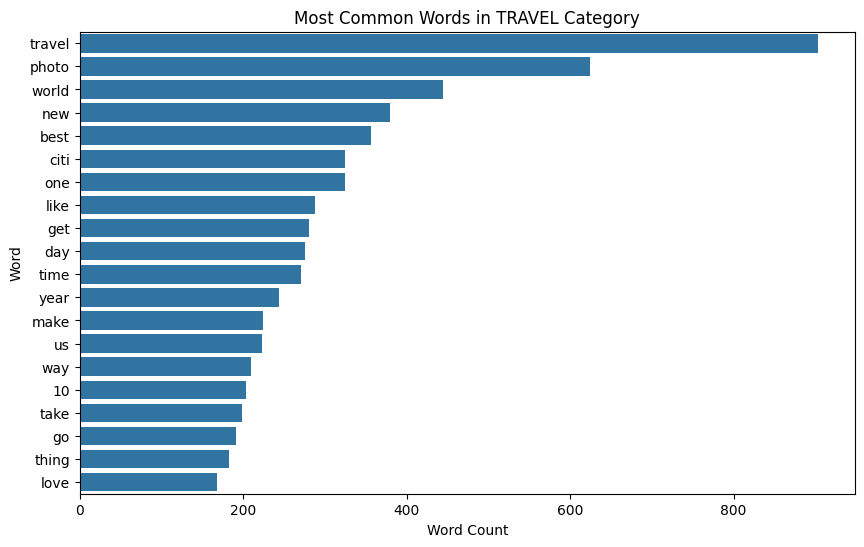

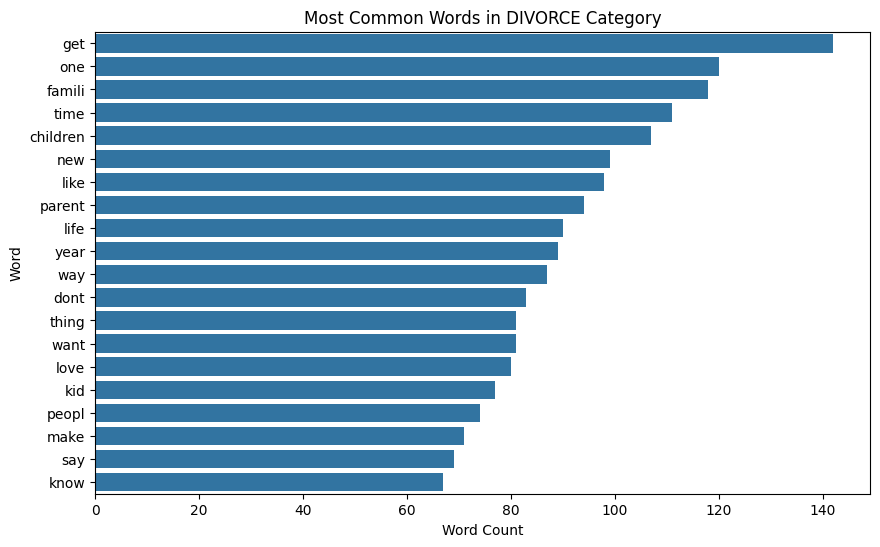

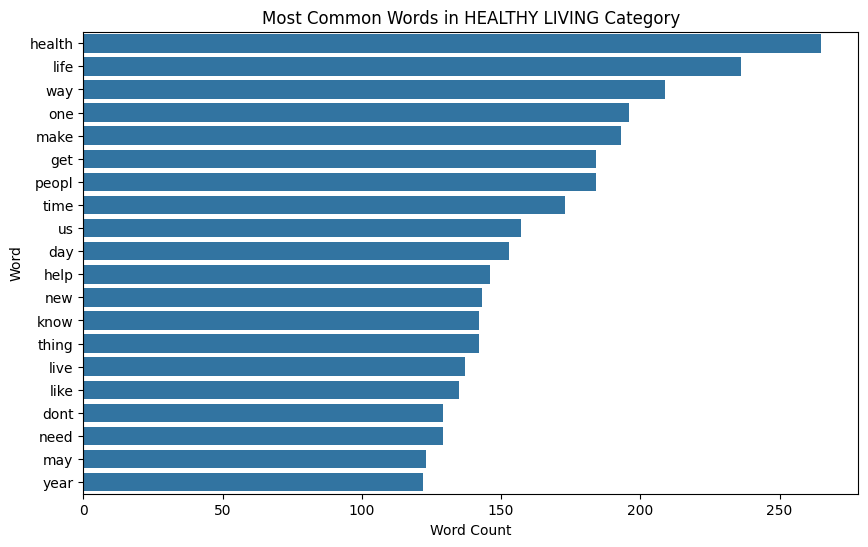

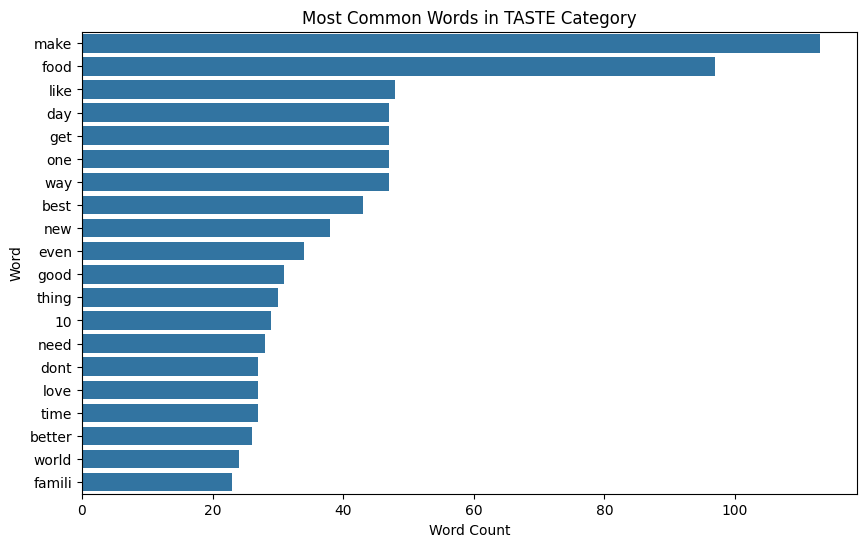

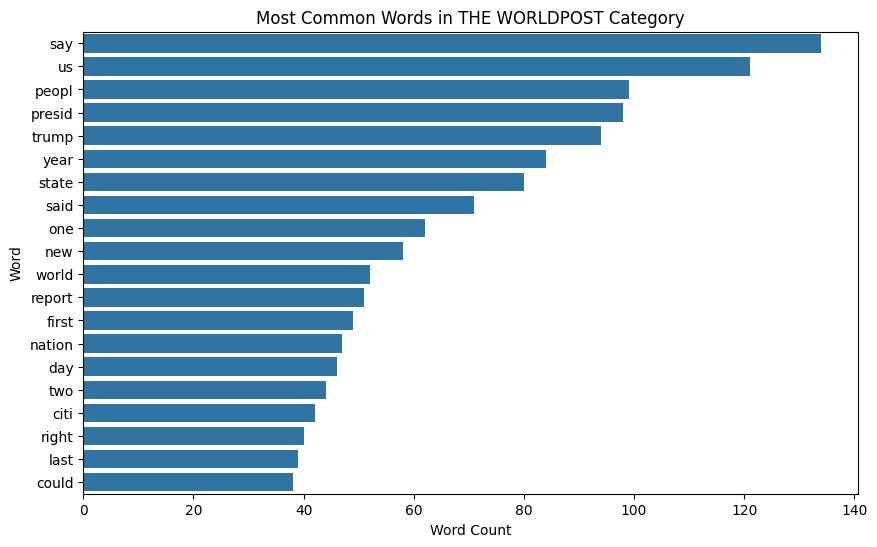

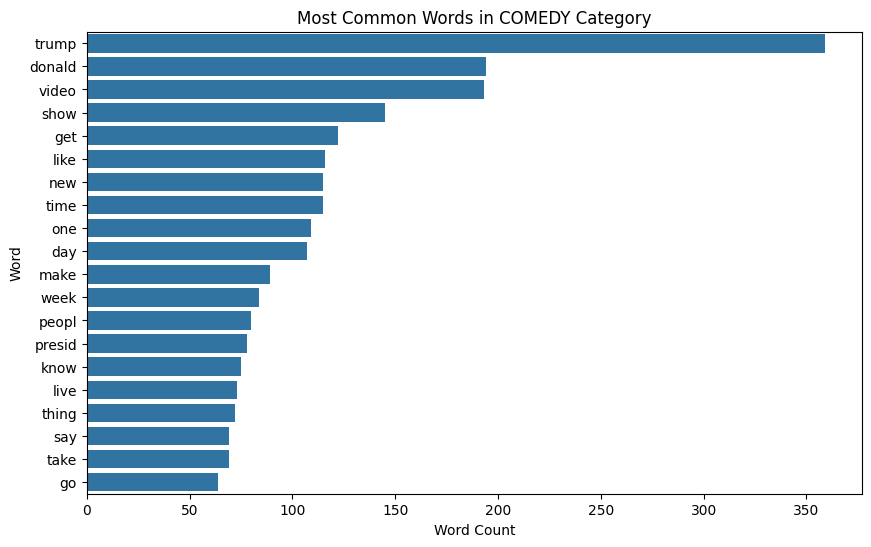

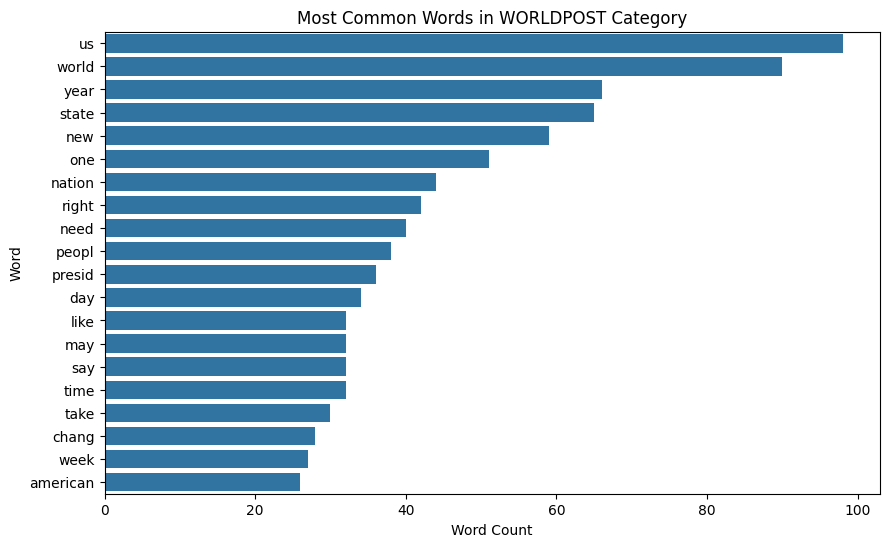

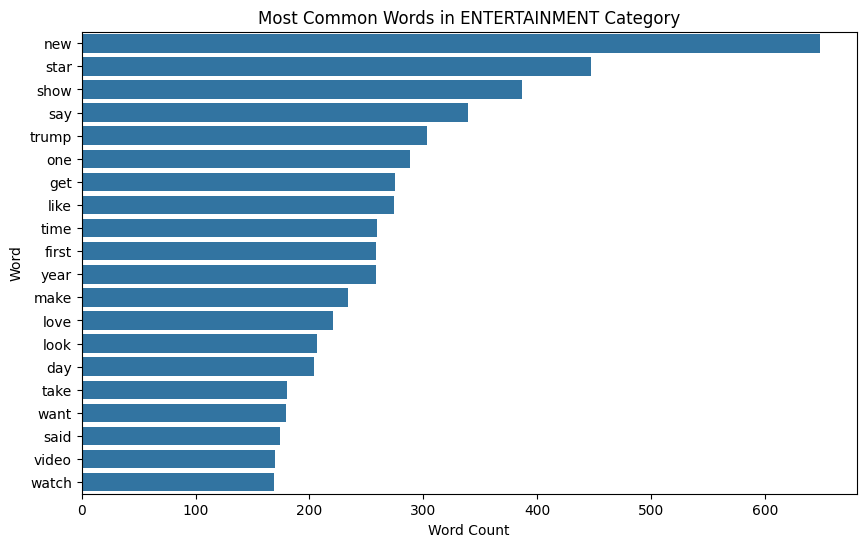

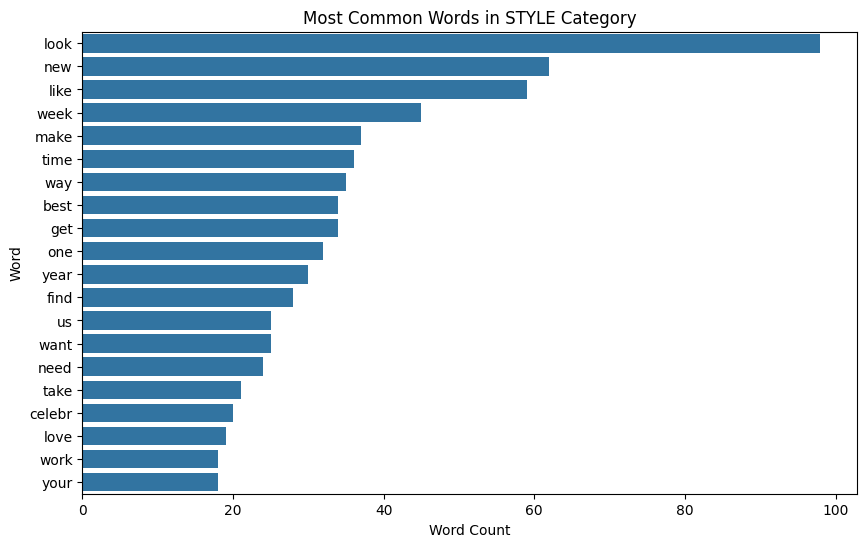

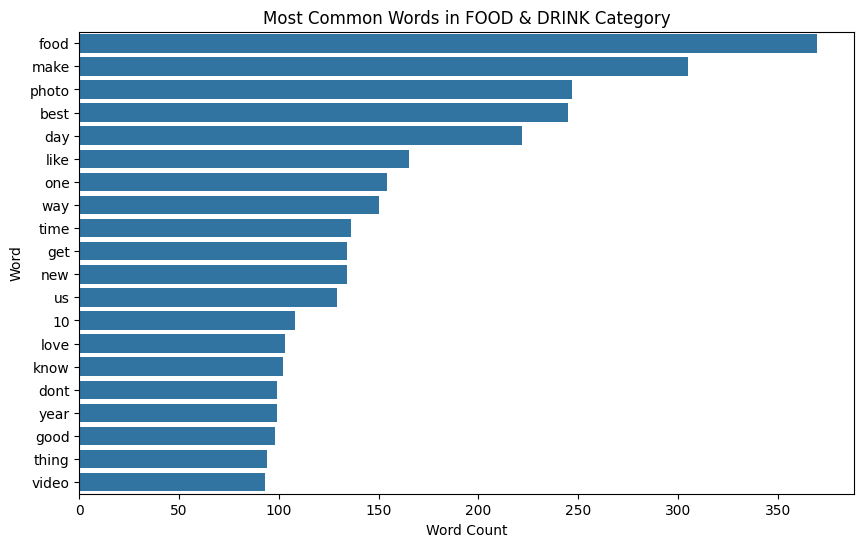

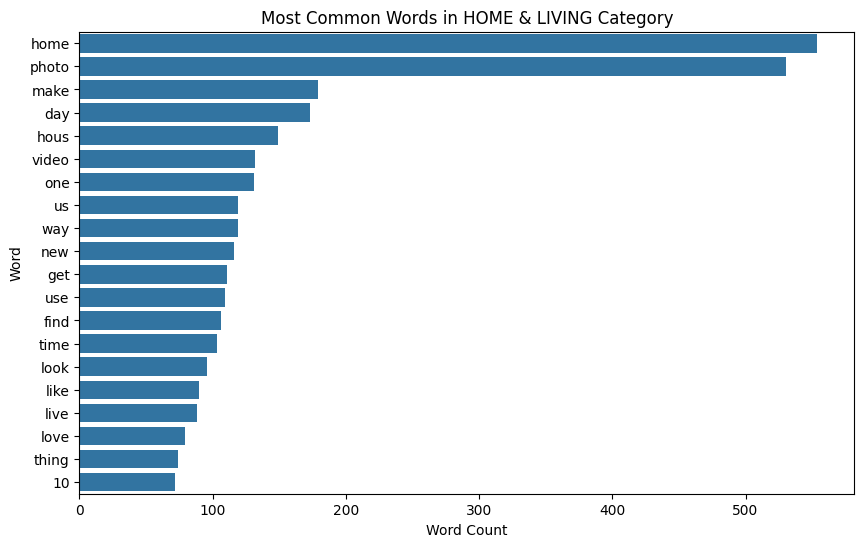

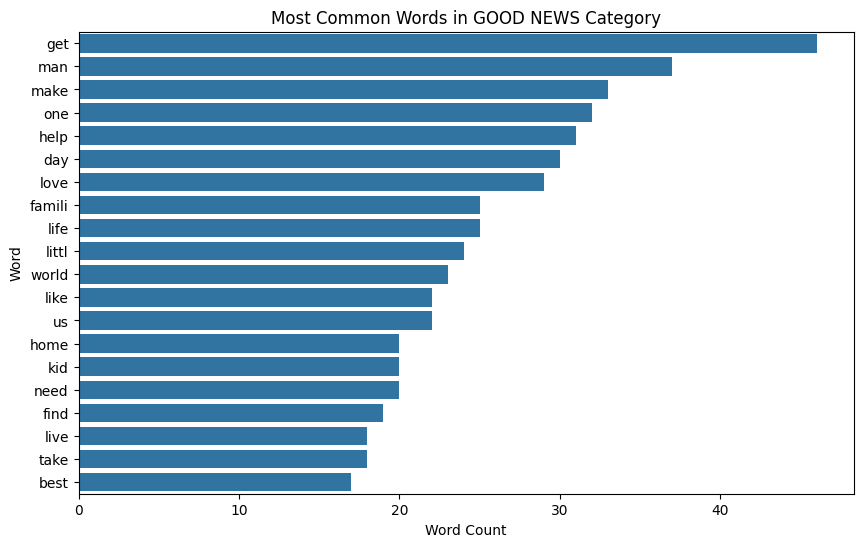

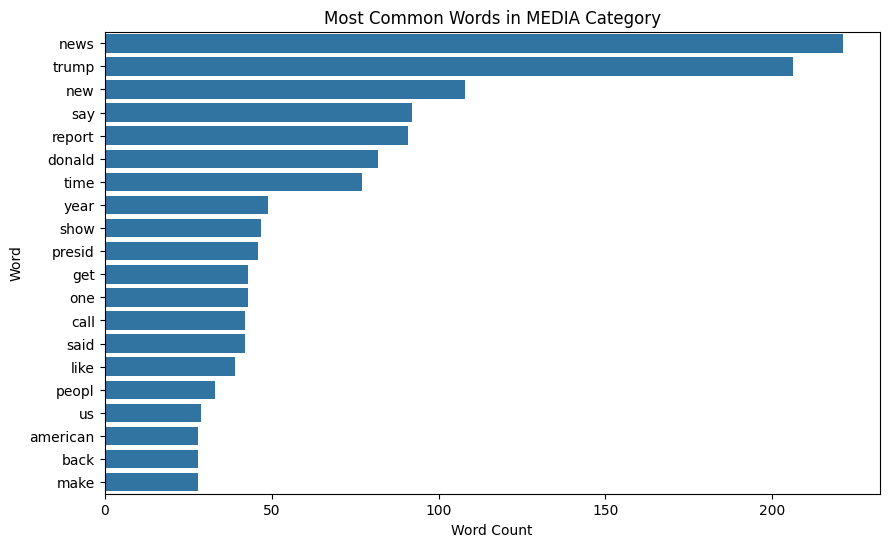

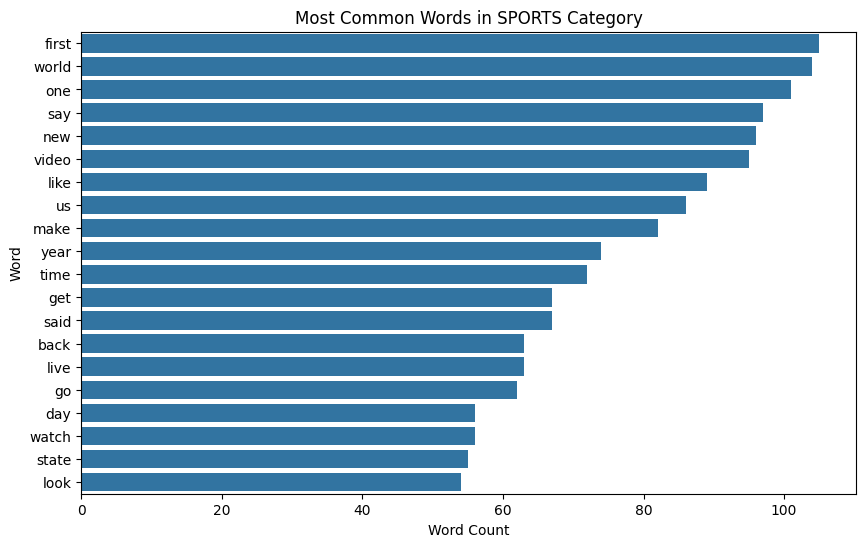

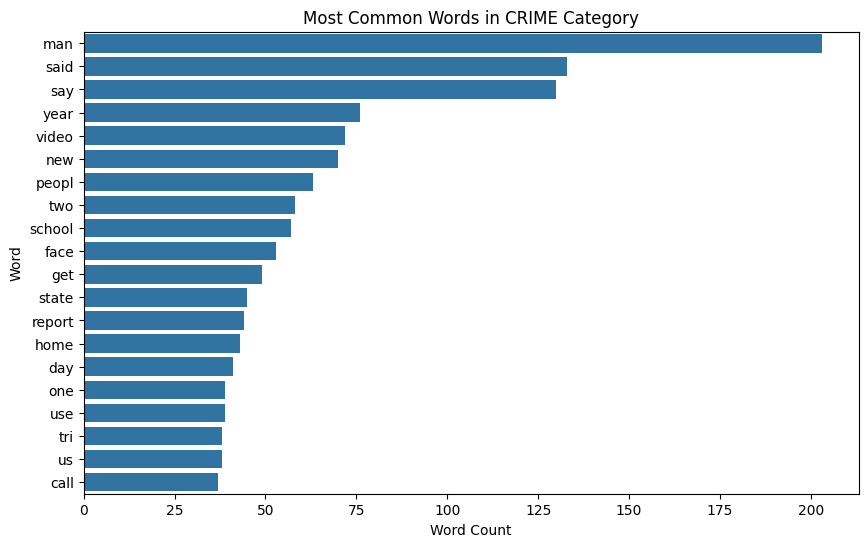

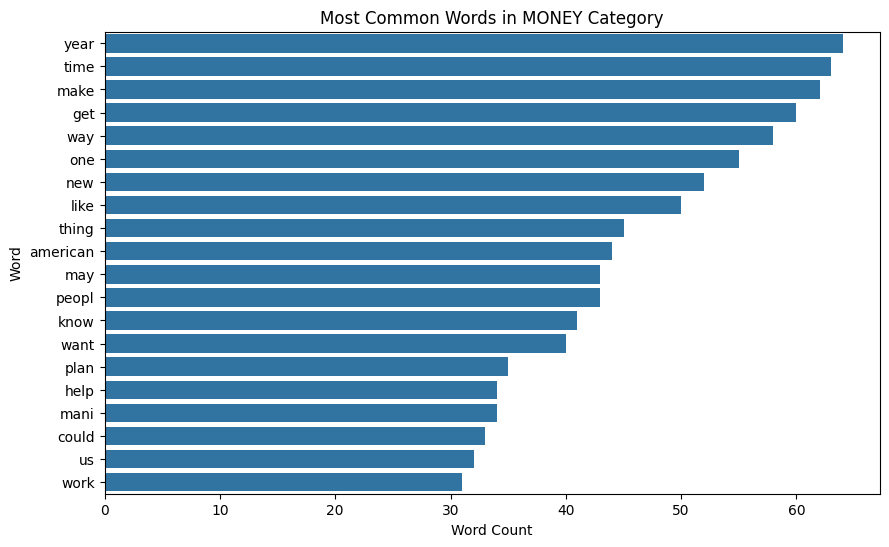

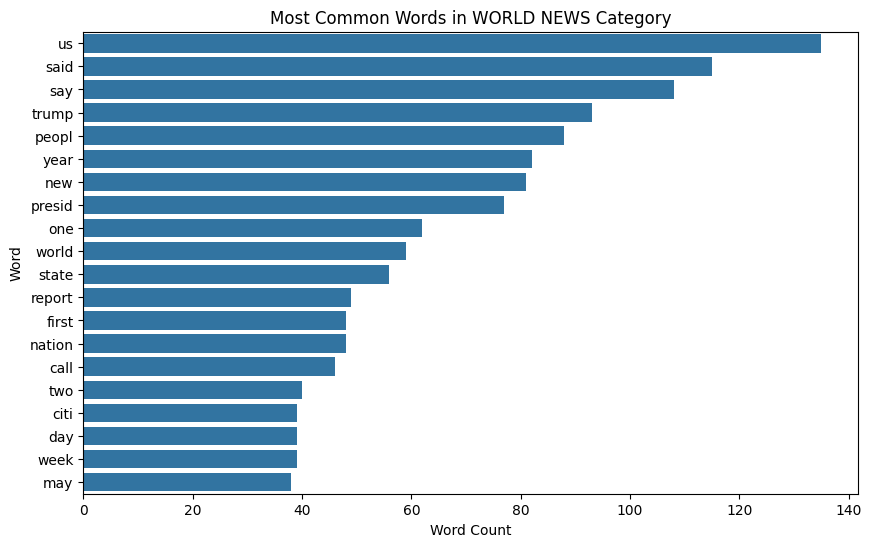

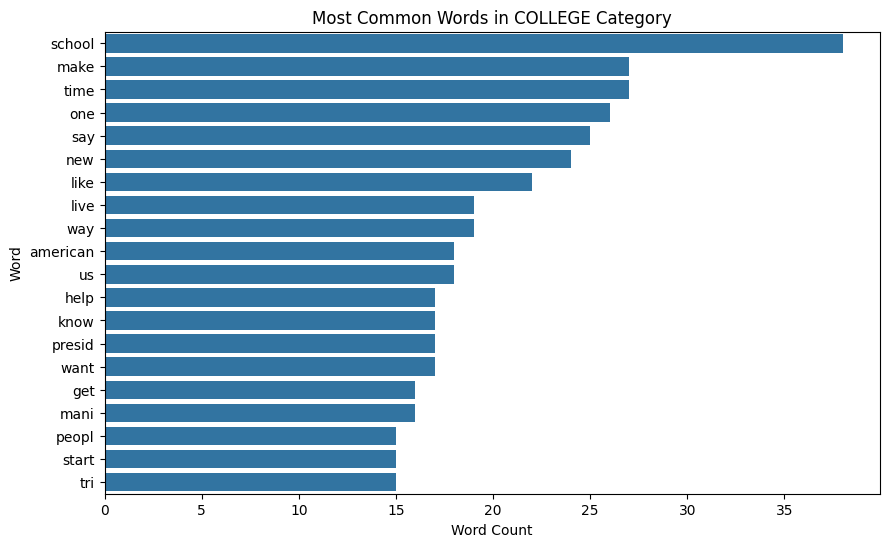

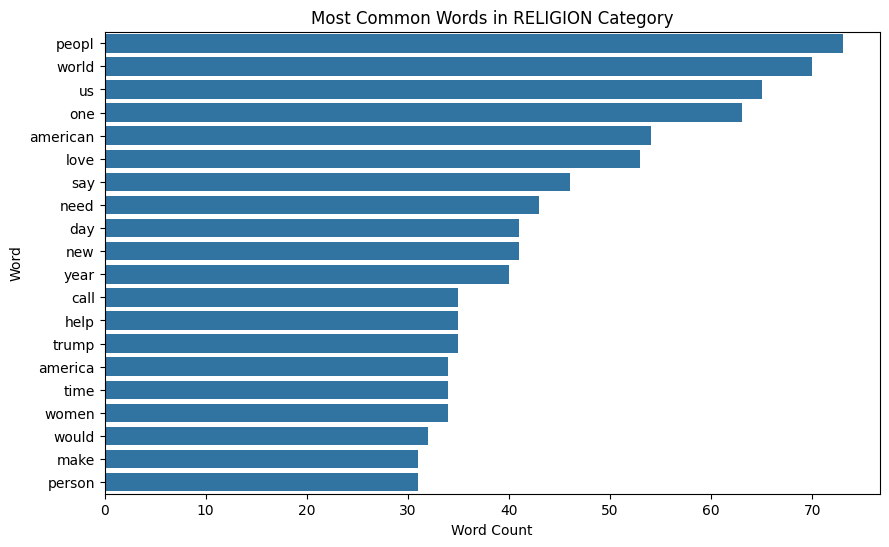

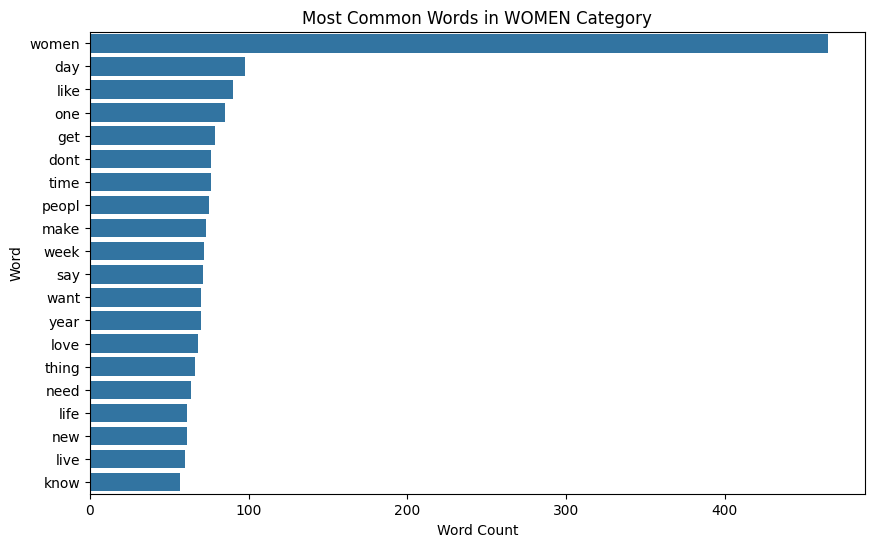

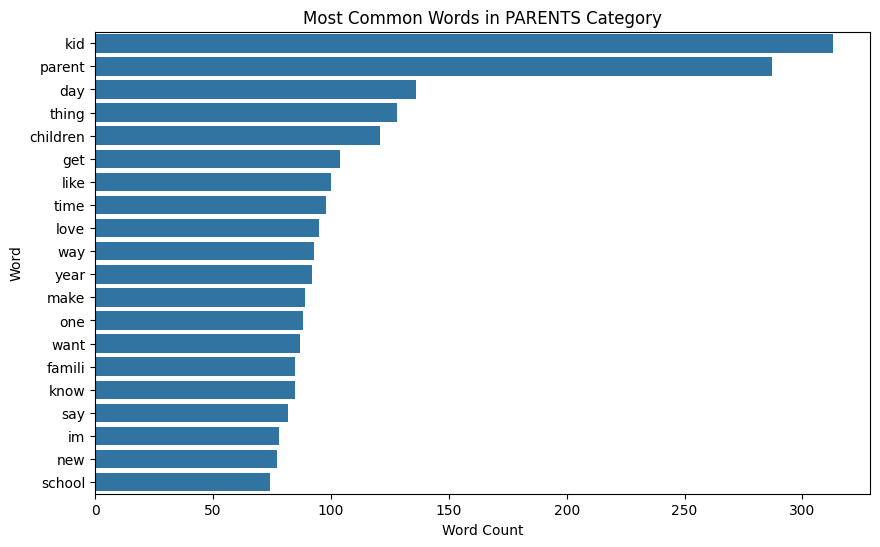

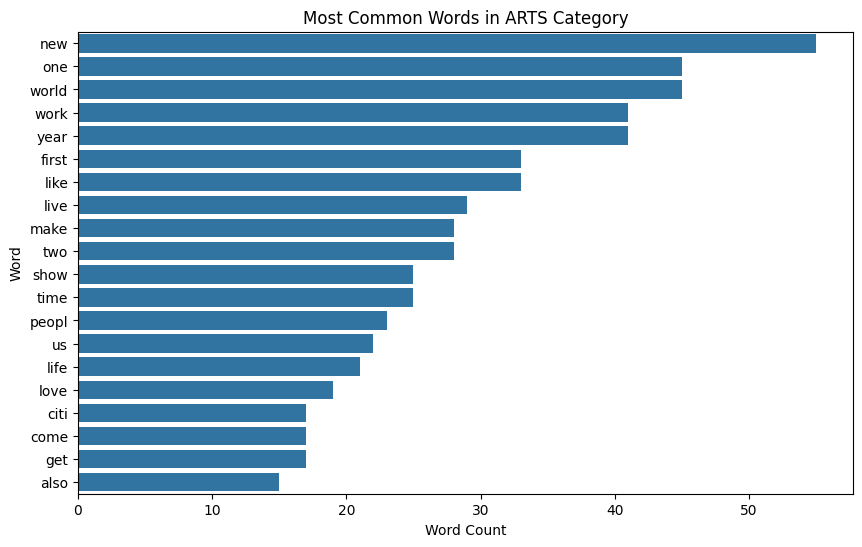

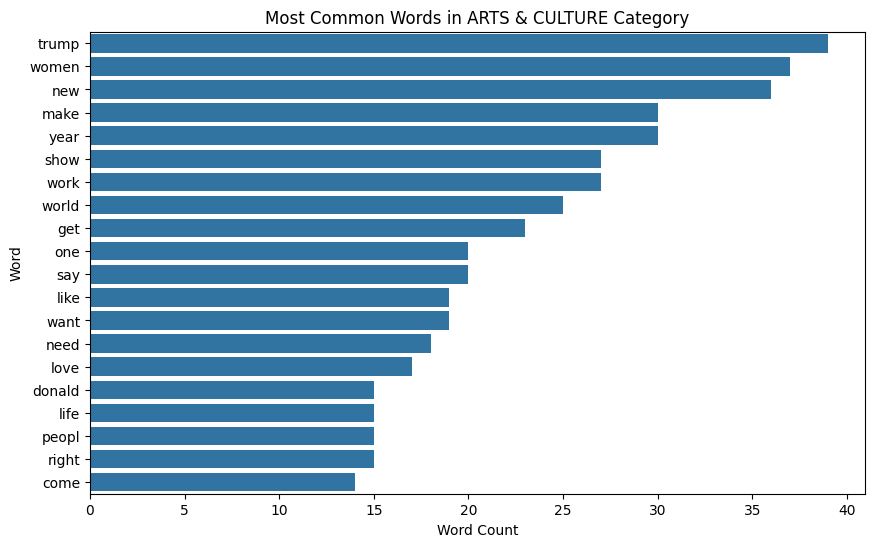

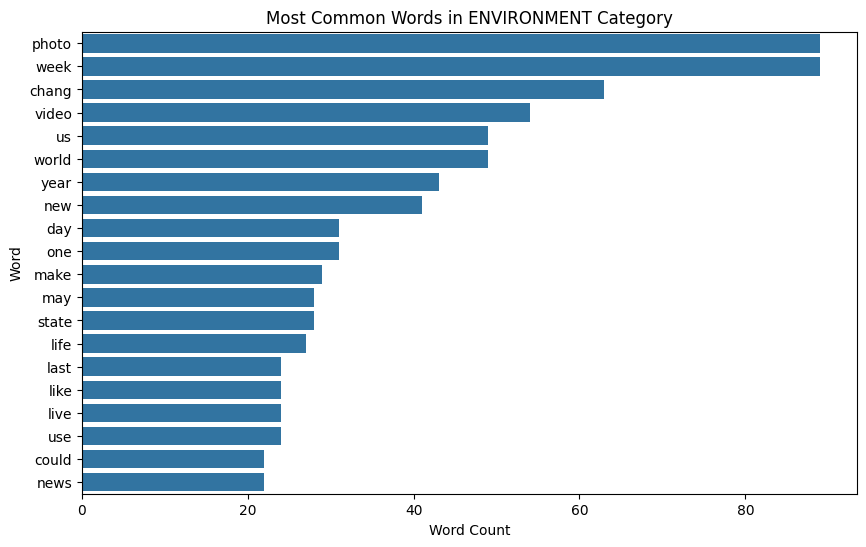

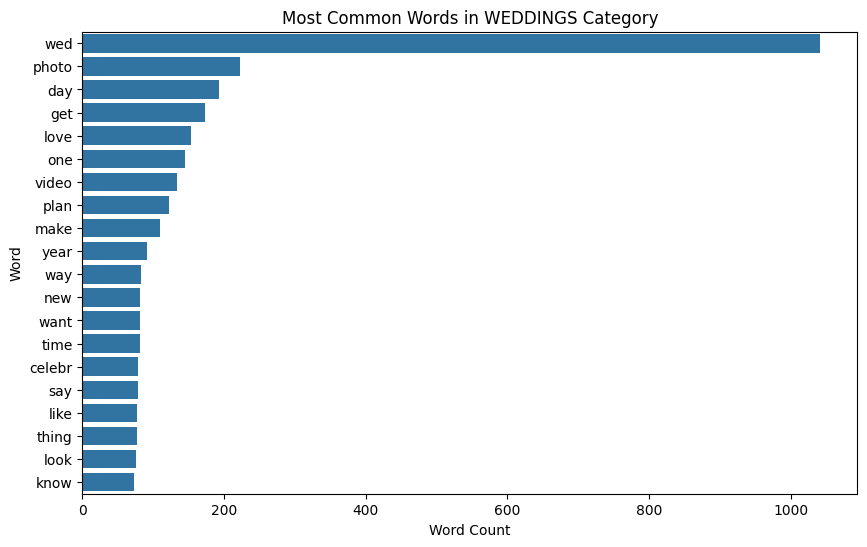

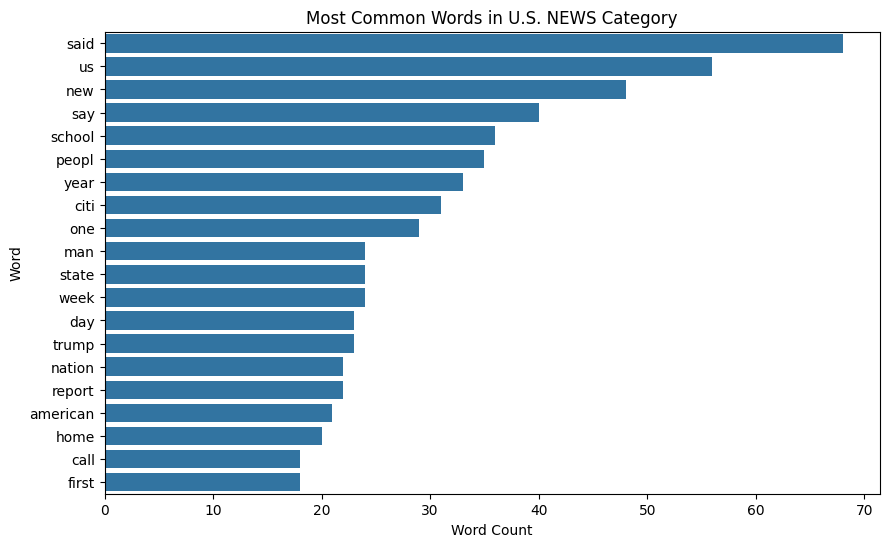

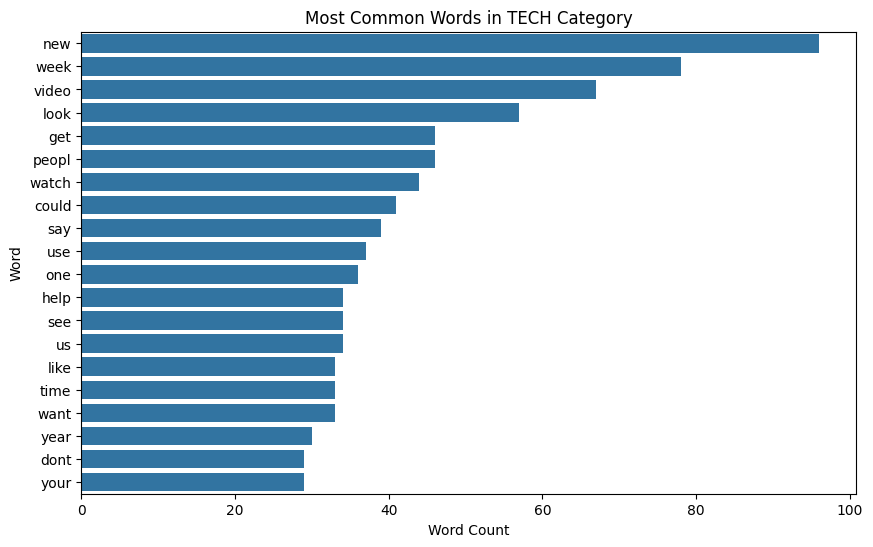

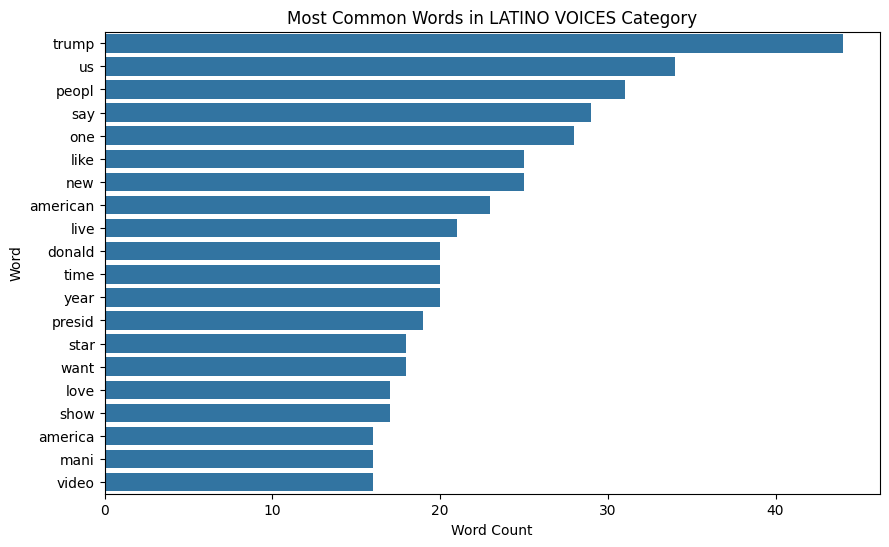

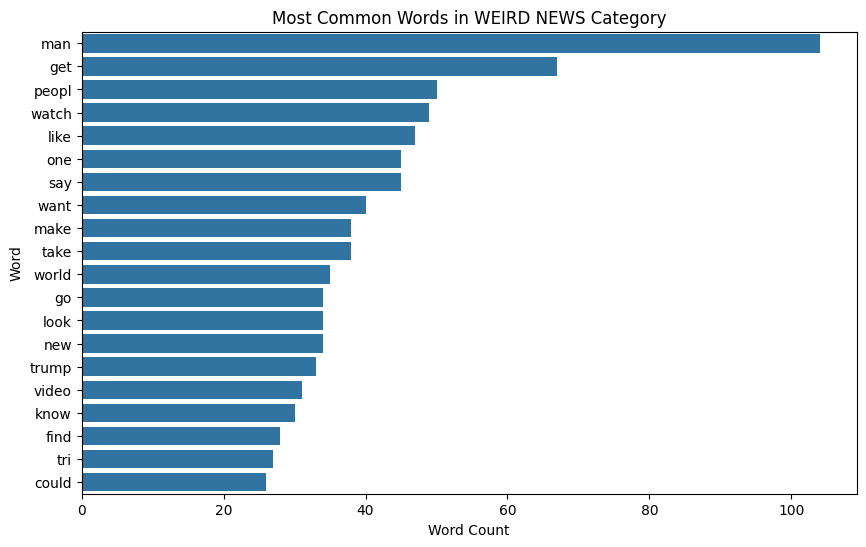

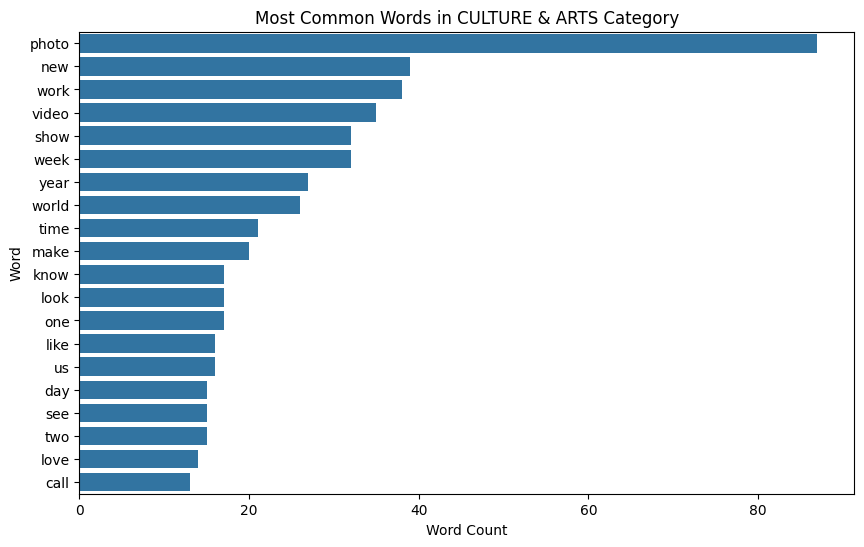

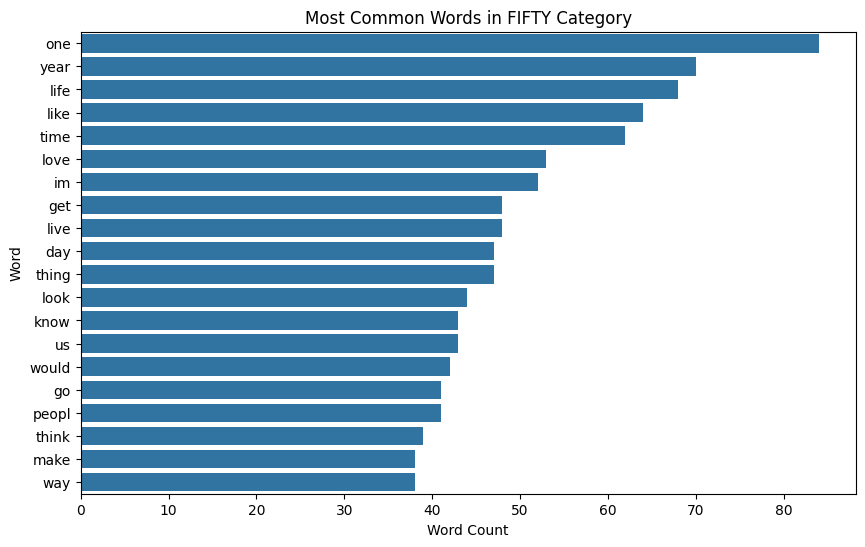

In [11]:
## examine the influence of different keywords on different categories; helps to understand how to distinguish features

from sklearn.feature_extraction.text import CountVectorizer

df['combined_text'] = df['cleaned_headline'] + ' ' + df['cleaned_short_description']

vectorizer = CountVectorizer(max_features=100)

word_counts = vectorizer.fit_transform(df['combined_text'])

vocab = vectorizer.get_feature_names_out()
word_counts = word_counts.sum(axis=0).A1

word_freq_df = pd.DataFrame({'word': vocab, 'count': word_counts})

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=word_freq_df.nlargest(20, 'count'))
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Most Common Words Overall')
plt.show()

for category in df['category'].unique():
    category_df = df[df['category'] == category]
    category_word_counts = vectorizer.transform(category_df['combined_text'])
    category_word_counts = category_word_counts.sum(axis=0).A1
    category_word_freq_df = pd.DataFrame({'word': vocab, 'count': category_word_counts})

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=category_word_freq_df.nlargest(20, 'count'))
    plt.xlabel('Word Count')
    plt.ylabel('Word')
    plt.title(f'Most Common Words in {category} Category')
    plt.show()

## Feature Engineering and Transformations

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [15]:
## unsample, separate text into features and categories, convert into numerics, and split into train and test

## unsample code to better balance data
max_size = df['category'].value_counts().max()
upsampled_chunks = []
for class_index, group in df.groupby('category'):
    upsampled_chunk = pd.concat([group] * (max_size // len(group)) + [group.sample(max_size % len(group), replace=True)])
    upsampled_chunks.append(upsampled_chunk)
df_balanced = pd.concat(upsampled_chunks)

X_resampled = df_balanced['combined_text']
y_resampled = df_balanced['category']

## convert to numerical representations
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_matrix = tfidf_vectorizer.fit_transform(X_resampled)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_resampled)

features_df = pd.concat([tfidf_df, pd.DataFrame({'category': encoded_labels})], axis=1)

print("Features DataFrame sample:\n", features_df.head())

max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_resampled)
sequences = tokenizer.texts_to_sequences(X_resampled)
X_resampled_padded = pad_sequences(sequences, maxlen=max_length)

label_map = {label: index for index, label in enumerate(y_resampled.unique())}
y_resampled_mapped = y_resampled.map(label_map).values

X_train, X_test, y_train, y_test = train_test_split(X_resampled_padded, y_resampled_mapped, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Features DataFrame sample:
     10  100   11   12   13   14   15   16   17   18  ...  youd  youll  young  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0    0.0    0.0   

   younger  your  youth  youtub  youv  zoo  category  
0      0.0   0.0    0.0     0.0   0.0  0.0         0  
1      0.0   0.0    0.0     0.0   0.0  0.0         0  
2      0.0   0.0    0.0     0.0   0.0  0.0         0  
3      0.0   0.0    0.0     0.0   0.0  0.0         0  
4      0.0   0.0    0.0     0.0   0.0  0.0         0  

[5 rows x 2001 columns]
X_train shape: (357940, 100)
X_test shape: (89486, 100)
y_train shape: (357940,)
y_test shape: (89486,)


## Modeling

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


In [ ]:
## define the different models we'll be testing

models = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVC', LinearSVC()),
]

In [ ]:
## evaluate different baseline models to find the best one

import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

cv_folds = 3

cv_subset_size = 0.1

cv_subset_indices = resample(range(X_train.shape[0]), n_samples=int(X_train.shape[0] * cv_subset_size), random_state=42)
X_train_subset = X_train[cv_subset_indices]
y_train_subset = y_train[cv_subset_indices]

cv_scores = []
for name, model in models:
    scores = cross_val_score(model, X_train_subset, y_train_subset, cv=cv_folds, scoring='accuracy', n_jobs=-1)
    cv_scores.append((name, scores.mean(), scores.std()))

for name, mean_score, std_score in cv_scores:
    print(f"{name}: Mean Accuracy = {mean_score:.3f}, Std Deviation = {std_score:.3f}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Multinomial Naive Bayes: Mean Accuracy = 0.054, Std Deviation = 0.001
Logistic Regression: Mean Accuracy = 0.054, Std Deviation = 0.000
Random Forest: Mean Accuracy = 0.517, Std Deviation = 0.003
Linear SVC: Mean Accuracy = 0.049, Std Deviation = 0.005


In [ ]:
## find the best performing model, train, and evaluate against test set

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_model = models[np.argmax([score[1] for score in cv_scores])][1]

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nBest Model: {type(best_model).__name__}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

KeyboardInterrupt: 

## Deep Learning - CNN

In [17]:
## tokenize and pad sequences

max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['combined_text'])
sequences = tokenizer.texts_to_sequences(df['combined_text'])
X = pad_sequences(sequences, maxlen=max_length)

label_map = {label: index for index, label in enumerate(df['category'].unique())}
y = df['category'].map(label_map).values

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.6 MB/s eta 0:00:00


In [37]:
## create CNN model

import numpy as np
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

def create_model(embedding_dim=128, conv_filters=64, conv_kernel_size=5, dense_units=128, learning_rate=0.001, dropout_rate=0.5, l2_strength=0.02):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_length),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        GlobalMaxPooling1D(),
        Dense(dense_units, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(dropout_rate),
        Dense(dense_units // 2, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(dropout_rate),
        Dense(len(label_map), activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.build((None, max_length))
    return model

param_dist = {
    'model__embedding_dim': randint(64, 129),
    'model__conv_filters': randint(32, 65),
    'model__conv_kernel_size': randint(3, 6),
    'model__dense_units': randint(64, 129),
    'model__learning_rate': uniform(0.0001, 0.0005),
    'model__dropout_rate': uniform(0.4, 0.5),
    'model__l2_strength': uniform(0.01, 0.015)
}

model = KerasClassifier(model=create_model, epochs=10, batch_size=16, verbose=1)

X_train_subset, y_train_subset = resample(X_train_dl, y_train_dl, n_samples=5000, random_state=42)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=2, n_jobs=-1, random_state=42)
random_search_result = random_search.fit(X_train_subset, y_train_subset)

print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

best_model = random_search_result.best_estimator_

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

y_pred = best_model.predict(X_test_dl)

accuracy = accuracy_score(y_test_dl, y_pred)
precision = precision_score(y_test_dl, y_pred, average='weighted')
recall = recall_score(y_test_dl, y_pred, average='weighted')
f1 = f1_score(y_test_dl, y_pred, average='weighted')

print(f"\nCNN Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.0482 - loss: 9.4787
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1576 - loss: 7.4514
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2293 - loss: 6.0833
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2571 - loss: 5.1648
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3255 - loss: 4.3965
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3627 - loss: 3.8163
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4135 - loss: 3.3271
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4290 - loss: 3.0157
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4619 - loss: 2.7465
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4741 - loss: 2.5614
Best: 0.256600 using {'model__conv_filters': 55, 'model__conv_kernel_size': 5, 'model__dense_units': 74, 'model__dropout_rate': 0.4994212020444026, 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2829/2829 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.1491 - loss: 6.8167 - val_accuracy: 0.2965 - val_loss: 3.0253
Epoch 2/10
2829/2829 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.3357 - loss: 2.8823 - val_accuracy: 0.3872 - val_loss: 2.5226
Epoch 3/10
2829/2829 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3827 - loss: 2.5530 - val_accuracy: 0.4106 - val_loss: 2.3848
Epoch 4/10
2829/2829 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4176 - loss: 2.3940 - val_accuracy: 0.4025 - val_loss: 2.3967
Epoch 5/10
2829/2829 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4522 - loss: 2.2484 - val_accuracy: 0.4675 - val_loss: 2.2064
Epoch 6/10
2829/2829 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4748 - loss: 2.1396 - val_accuracy: 0.4460 - val_loss: 2.2631
Epoch 7/10
2829/2829 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4902 - loss: 2.0557 - val_accuracy: 0.4472 - val_loss: 2.2710
Epoch 8/10
2829/2829 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5057 - loss: 1.9870 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                precision    recall  f1-score   support

        IMPACT       0.18      0.01      0.02       218
      BUSINESS       0.22      0.15      0.18       330
      POLITICS       0.60      0.83      0.69      2117
         GREEN       0.19      0.02      0.03       156
       SCIENCE       1.00      0.01      0.01       147
     PARENTING       0.44      0.61      0.51       536
      WELLNESS       0.54      0.71      0.61      1074
STYLE & BEAUTY       0.62      0.76      0.69       627
  QUEER VOICES       0.44      0.72      0.54       391
     EDUCATION       0.00      0.00      0.00        58
  BLACK VOICES       0.18      0.10      0.12       252
        TRAVEL       0.47      0.64      0.54       585
       DIVORCE       0.61      0.60      0.60       217
HEALTHY LIVING       0.40      0.09      0.14       431
         TASTE       0.00      0.00      0.00       138
 THE WORLDPOST       0.32      0.46      0.37       229
        COMEDY       0.1

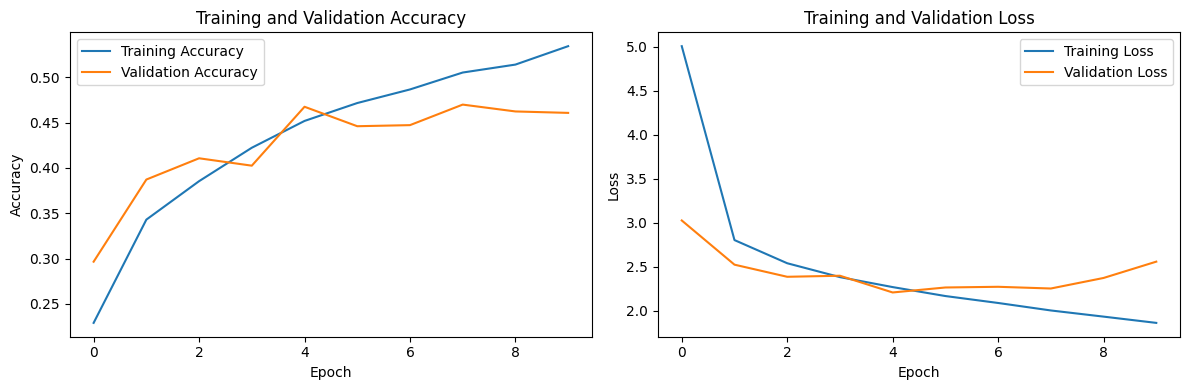

In [38]:
## plot training and validation accuracy and loss

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test_dl, y_pred, target_names=label_map.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_test_dl, y_pred))

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history_['accuracy'], label='Training Accuracy')
plt.plot(history.history_['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history_['loss'], label='Training Loss')
plt.plot(history.history_['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

## RNN

In [25]:
## create RNN model with accuracy, recall, precision, f1 score

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

class RNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, embedding_dim=128, lstm_units=128, dense_units=128, learning_rate=0.001, dropout_rate=0.5, l2_strength=0.02):
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.dense_units = dense_units
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.l2_strength = l2_strength
        self.model_ = None
        self.history_ = None  # Add history attribute

    def fit(self, X, y, **kwargs):
        self.model_ = create_rnn_model(
            self.embedding_dim, self.lstm_units, self.dense_units,
            self.learning_rate, self.dropout_rate, self.l2_strength
        )
        self.history_ = self.model_.fit(X, y, **kwargs)  # Store the history
        return self

    def predict(self, X):
        predictions = self.model_.predict(X)
        return np.argmax(predictions, axis=1)

    def score(self, X, y):
        _, accuracy = self.model_.evaluate(X, y, verbose=0)
        return accuracy

def create_rnn_model(embedding_dim, lstm_units, dense_units, learning_rate, dropout_rate, l2_strength):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_length),
        LSTM(lstm_units, return_sequences=True, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        Dropout(dropout_rate),
        LSTM(lstm_units, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(len(label_map), activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

param_dist = {
    'embedding_dim': randint(64, 129),
    'lstm_units': randint(64, 129),
    'dense_units': randint(64, 129),
    'learning_rate': uniform(0.0001, 0.0005),
    'dropout_rate': uniform(0.4, 0.5),
    'l2_strength': uniform(0.01, 0.015)
}

X_train_subset, y_train_subset = resample(X_train_dl, y_train_dl, n_samples=5000, random_state=42)

random_search = RandomizedSearchCV(estimator=RNNClassifier(), param_distributions=param_dist, n_iter=20, cv=2, n_jobs=-1, random_state=42)
random_search_result = random_search.fit(X_train_subset, y_train_subset)

print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

best_model = random_search_result.best_estimator_

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train_dl, y_train_dl, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

y_pred = best_model.predict(X_test_dl)

accuracy = accuracy_score(y_test_dl, y_pred)
precision = precision_score(y_test_dl, y_pred, average='weighted')
recall = recall_score(y_test_dl, y_pred, average='weighted')
f1 = f1_score(y_test_dl, y_pred, average='weighted')

print(f"\nDeep Learning Model (RNN):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0249 - loss: 9.3194
Best: 0.133800 using {'dense_units': 66, 'dropout_rate': 0.41029224714790125, 'embedding_dim': 65, 'l2_strength': 0.02082998158400237, 'learning_rate': 0.0005692763545078751, 'lstm_units': 65}
Epoch 1/20
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.1985 - loss: 6.1290 - val_accuracy: 0.3724 - val_loss: 2.9612
Epoch 2/20
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.4527 - loss: 2.4578 - val_accuracy: 0.3388 - val_loss: 2.7130
Epoch 3/20
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5290 - loss: 1.9614 - val_accuracy: 0.4711 - val_loss: 2.1746
Epoch 4/20
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5705 - loss: 1.7420 - val_accuracy: 0.4341 - val_loss: 2.3216
Epoch 5/20
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5963 - loss: 1.6214 - val_accuracy: 0.4719 - val_loss: 2.1715
Epoch 6/20
1415/1415 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


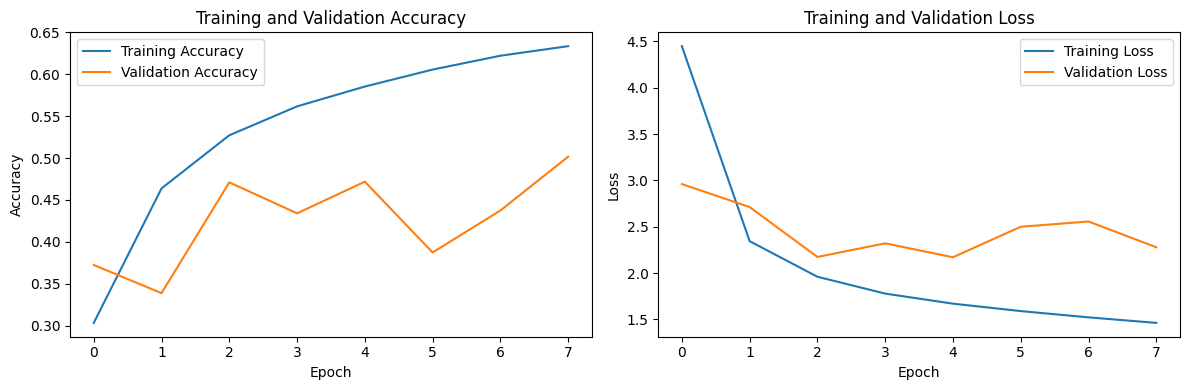

Classification Report:
                precision    recall  f1-score   support

        IMPACT       0.26      0.05      0.08       218
      BUSINESS       0.22      0.40      0.28       330
      POLITICS       0.67      0.76      0.71      2117
         GREEN       0.35      0.05      0.09       156
       SCIENCE       0.80      0.22      0.34       147
     PARENTING       0.50      0.57      0.53       536
      WELLNESS       0.53      0.74      0.62      1074
STYLE & BEAUTY       0.73      0.74      0.74       627
  QUEER VOICES       0.15      0.83      0.25       391
     EDUCATION       0.00      0.00      0.00        58
  BLACK VOICES       0.31      0.22      0.26       252
        TRAVEL       0.63      0.60      0.61       585
       DIVORCE       0.90      0.59      0.71       217
HEALTHY LIVING       0.32      0.16      0.21       431
         TASTE       0.07      0.01      0.01       138
 THE WORLDPOST       0.40      0.35      0.37       229
        COMEDY       0.4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
## Evaluate training and validation accuracy and loss

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(best_model.history_.history['accuracy'], label='Training Accuracy')
plt.plot(best_model.history_.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(best_model.history_.history['loss'], label='Training Loss')
plt.plot(best_model.history_.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_test_dl, y_pred, target_names=label_map.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_test_dl, y_pred))